In [1]:
import pandas as pd
import numpy as np
import copy
import pickle

from surprise import KNNBaseline, KNNWithMeans, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNBasic, SVD
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from scipy import spatial
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [172]:
reviews= pd.read_csv('~/Desktop/capstone3.2/Capstone3/data/reviews.csv')


In [3]:
reviews_1= reviews[['beer_id', 'username','look','smell','taste','feel','overall','score']].sort_values(['beer_id'], ascending=True)
reviews_1 = reviews_1.reset_index()
reviews_1 = reviews_1.fillna(0)
reviews_1 = reviews_1.drop(['index'], axis = 1)
reviews_1.head()

,beer_id,username,look,smell,taste,feel,overall,score
0,3,Jason,3.5,4.0,4.0,4.5,4.0,4.02
1,3,Morris729,4.0,3.5,4.0,4.0,4.0,3.88
2,3,MAB,4.0,4.5,4.5,4.0,4.5,4.42
3,4,allengarvin,3.5,3.5,3.5,4.0,3.5,3.55
4,4,bditty187,4.0,3.0,3.0,3.5,3.5,3.21


In [4]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073128 entries, 0 to 9073127
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   int64  
 1   username  object 
 2   look      float64
 3   smell     float64
 4   taste     float64
 5   feel      float64
 6   overall   float64
 7   score     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 553.8+ MB


In [174]:
beers = pd.read_csv('~/Desktop/Capstone3.2/Capstone3/data/beers.csv')
beers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358873 entries, 0 to 358872
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            358873 non-null  int64  
 1   name          358873 non-null  object 
 2   brewery_id    358873 non-null  int64  
 3   state         298147 non-null  object 
 4   country       358719 non-null  object 
 5   style         358872 non-null  object 
 6   availability  358873 non-null  object 
 7   abv           320076 non-null  float64
 8   notes         358827 non-null  object 
 9   retired       358873 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 27.4+ MB


In [6]:
beers_1= beers[['id', 'name', 'brewery_id', 'style']]
beers_1 = beers_1.rename(columns= {'id':'beer_id', 'name':'beer_name'})
beers_1 = beers_1.sort_values(['beer_id'], ascending= True)
#beers_1.set_index('beer_id')
beers_1.head()

,beer_id,beer_name,brewery_id,style
8752,3,Cactus Queen IPA,2,American IPA
8760,4,Wildcatter's Crude Stout,2,American Stout
8817,5,Amber,3,Vienna Lager
8818,6,Turbodog,3,English Brown Ale
8819,7,Purple Haze,3,Fruit and Field Beer


In [175]:
brewery = pd.read_csv('~/Desktop/Capstone3.2/Capstone3/data/breweries.csv')
brewery.head(3)

,id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"


In [8]:
brewery_1 = brewery[['id', 'name']]
brewery_1 = brewery_1.rename(columns={'id':'brewery_id', 'name':'brewery_name'})
brewery_1 = brewery_1.sort_values(['brewery_id'])

brewery_1.head(10)

,brewery_id,brewery_name
17575,1,Plzeňský Prazdroj
16112,2,Yellow Rose Brewing Company
23348,3,Abita Brewing Co.
38987,4,Allagash Brewing Company
49940,5,Yakima Brewing Co. / Bert Grant's Ales
18806,6,Brouwerij Slaghmuylder
38157,8,Widmer Brothers Brewing Company
40270,9,Whitbread PLC
18176,10,Whim Ales
7427,11,North East Brewing Company


In [9]:
both = pd.merge(brewery_1, beers_1[['brewery_id', 'style', 'beer_name', 'beer_id']], on = 'brewery_id')

both.head()

,brewery_id,brewery_name,style,beer_name,beer_id
0,1,Plzeňský Prazdroj,Bohemian Pilsener,Pilsner Urquell,429
1,1,Plzeňský Prazdroj,Bohemian Pilsener,Gambrinus,5916
2,1,Plzeňský Prazdroj,Bohemian Pilsener,Eisbrau Czech,14348
3,1,Plzeňský Prazdroj,Bohemian Pilsener,Primus,19099
4,1,Plzeňský Prazdroj,Bohemian Pilsener,Gambrinus Pale,19123


In [10]:
all_three = pd.merge(reviews_1, both[['beer_name','brewery_name','style', 'beer_id']], on = 'beer_id')
all_three_1 = all_three.drop(['beer_id'], axis=1)
all_three_1.tail()

,username,look,smell,taste,feel,overall,score,beer_name,brewery_name,style
9072909,Mclusal,0.0,0.0,0.0,0.0,0.0,4.48,Aguila,Cervecería Bavaria,American Lager
9072910,Mclusal,0.0,0.0,0.0,0.0,0.0,2.25,Aguila Cero,Cervecería Bavaria,American Light Lager
9072911,pkalix,0.0,0.0,0.0,0.0,0.0,4.02,The Hunted,Boomtown Brewery,American Imperial IPA
9072912,bylerteck,0.0,0.0,0.0,0.0,0.0,3.53,Pineapple Wheat,Persimmon Hollow Brewing,German Hefeweizen
9072913,Pmicdee,0.0,0.0,0.0,0.0,0.0,3.25,Red Bull,Sleeman Breweries Ltd.,American Malt Liquor


In [11]:
all_three_1.head(10)

,username,look,smell,taste,feel,overall,score,beer_name,brewery_name,style
0,Jason,3.5,4.0,4.0,4.5,4.0,4.02,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
1,Morris729,4.0,3.5,4.0,4.0,4.0,3.88,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
2,MAB,4.0,4.5,4.5,4.0,4.5,4.42,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
3,allengarvin,3.5,3.5,3.5,4.0,3.5,3.55,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
4,bditty187,4.0,3.0,3.0,3.5,3.5,3.21,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
5,NeroFiddled,4.0,4.0,4.0,4.0,4.5,4.10,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
6,assurbanipaul,4.0,4.0,3.5,2.5,3.0,3.45,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
7,AtrumAnimus,5.0,4.5,5.0,5.0,5.0,4.88,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
8,GreenCard,2.5,3.0,2.0,4.0,3.0,2.67,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
9,Morris729,4.0,3.5,3.5,4.0,4.0,3.68,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout


In [12]:
all_three_1 =all_three_1.fillna(0)
all_three_1.tail(10)

,username,look,smell,taste,feel,overall,score,beer_name,brewery_name,style
9072904,pkalix,0.0,0.0,0.0,0.0,0.0,3.83,Welcome To Citra,Chapman Crafted Beer,American Lager
9072905,pkalix,0.0,0.0,0.0,0.0,0.0,3.74,Warhop,Arrow Lodge Brewing,American Pale Ale (APA)
9072906,WillieThreebiers,0.0,0.0,0.0,0.0,0.0,4.17,Haller Blanc Girl,30 Mile Brewing Co.,New England IPA
9072907,emerge077,0.0,0.0,0.0,0.0,0.0,4.00,Red MONKey,Klosterbrauerei Weissenohe / Klosterbrauerei W...,German Kellerbier / Zwickelbier
9072908,WillieThreebiers,0.0,0.0,0.0,0.0,0.0,4.07,Hop Arbor,Barley Head Brewery,American Imperial IPA
9072909,Mclusal,0.0,0.0,0.0,0.0,0.0,4.48,Aguila,Cervecería Bavaria,American Lager
9072910,Mclusal,0.0,0.0,0.0,0.0,0.0,2.25,Aguila Cero,Cervecería Bavaria,American Light Lager
9072911,pkalix,0.0,0.0,0.0,0.0,0.0,4.02,The Hunted,Boomtown Brewery,American Imperial IPA
9072912,bylerteck,0.0,0.0,0.0,0.0,0.0,3.53,Pineapple Wheat,Persimmon Hollow Brewing,German Hefeweizen
9072913,Pmicdee,0.0,0.0,0.0,0.0,0.0,3.25,Red Bull,Sleeman Breweries Ltd.,American Malt Liquor


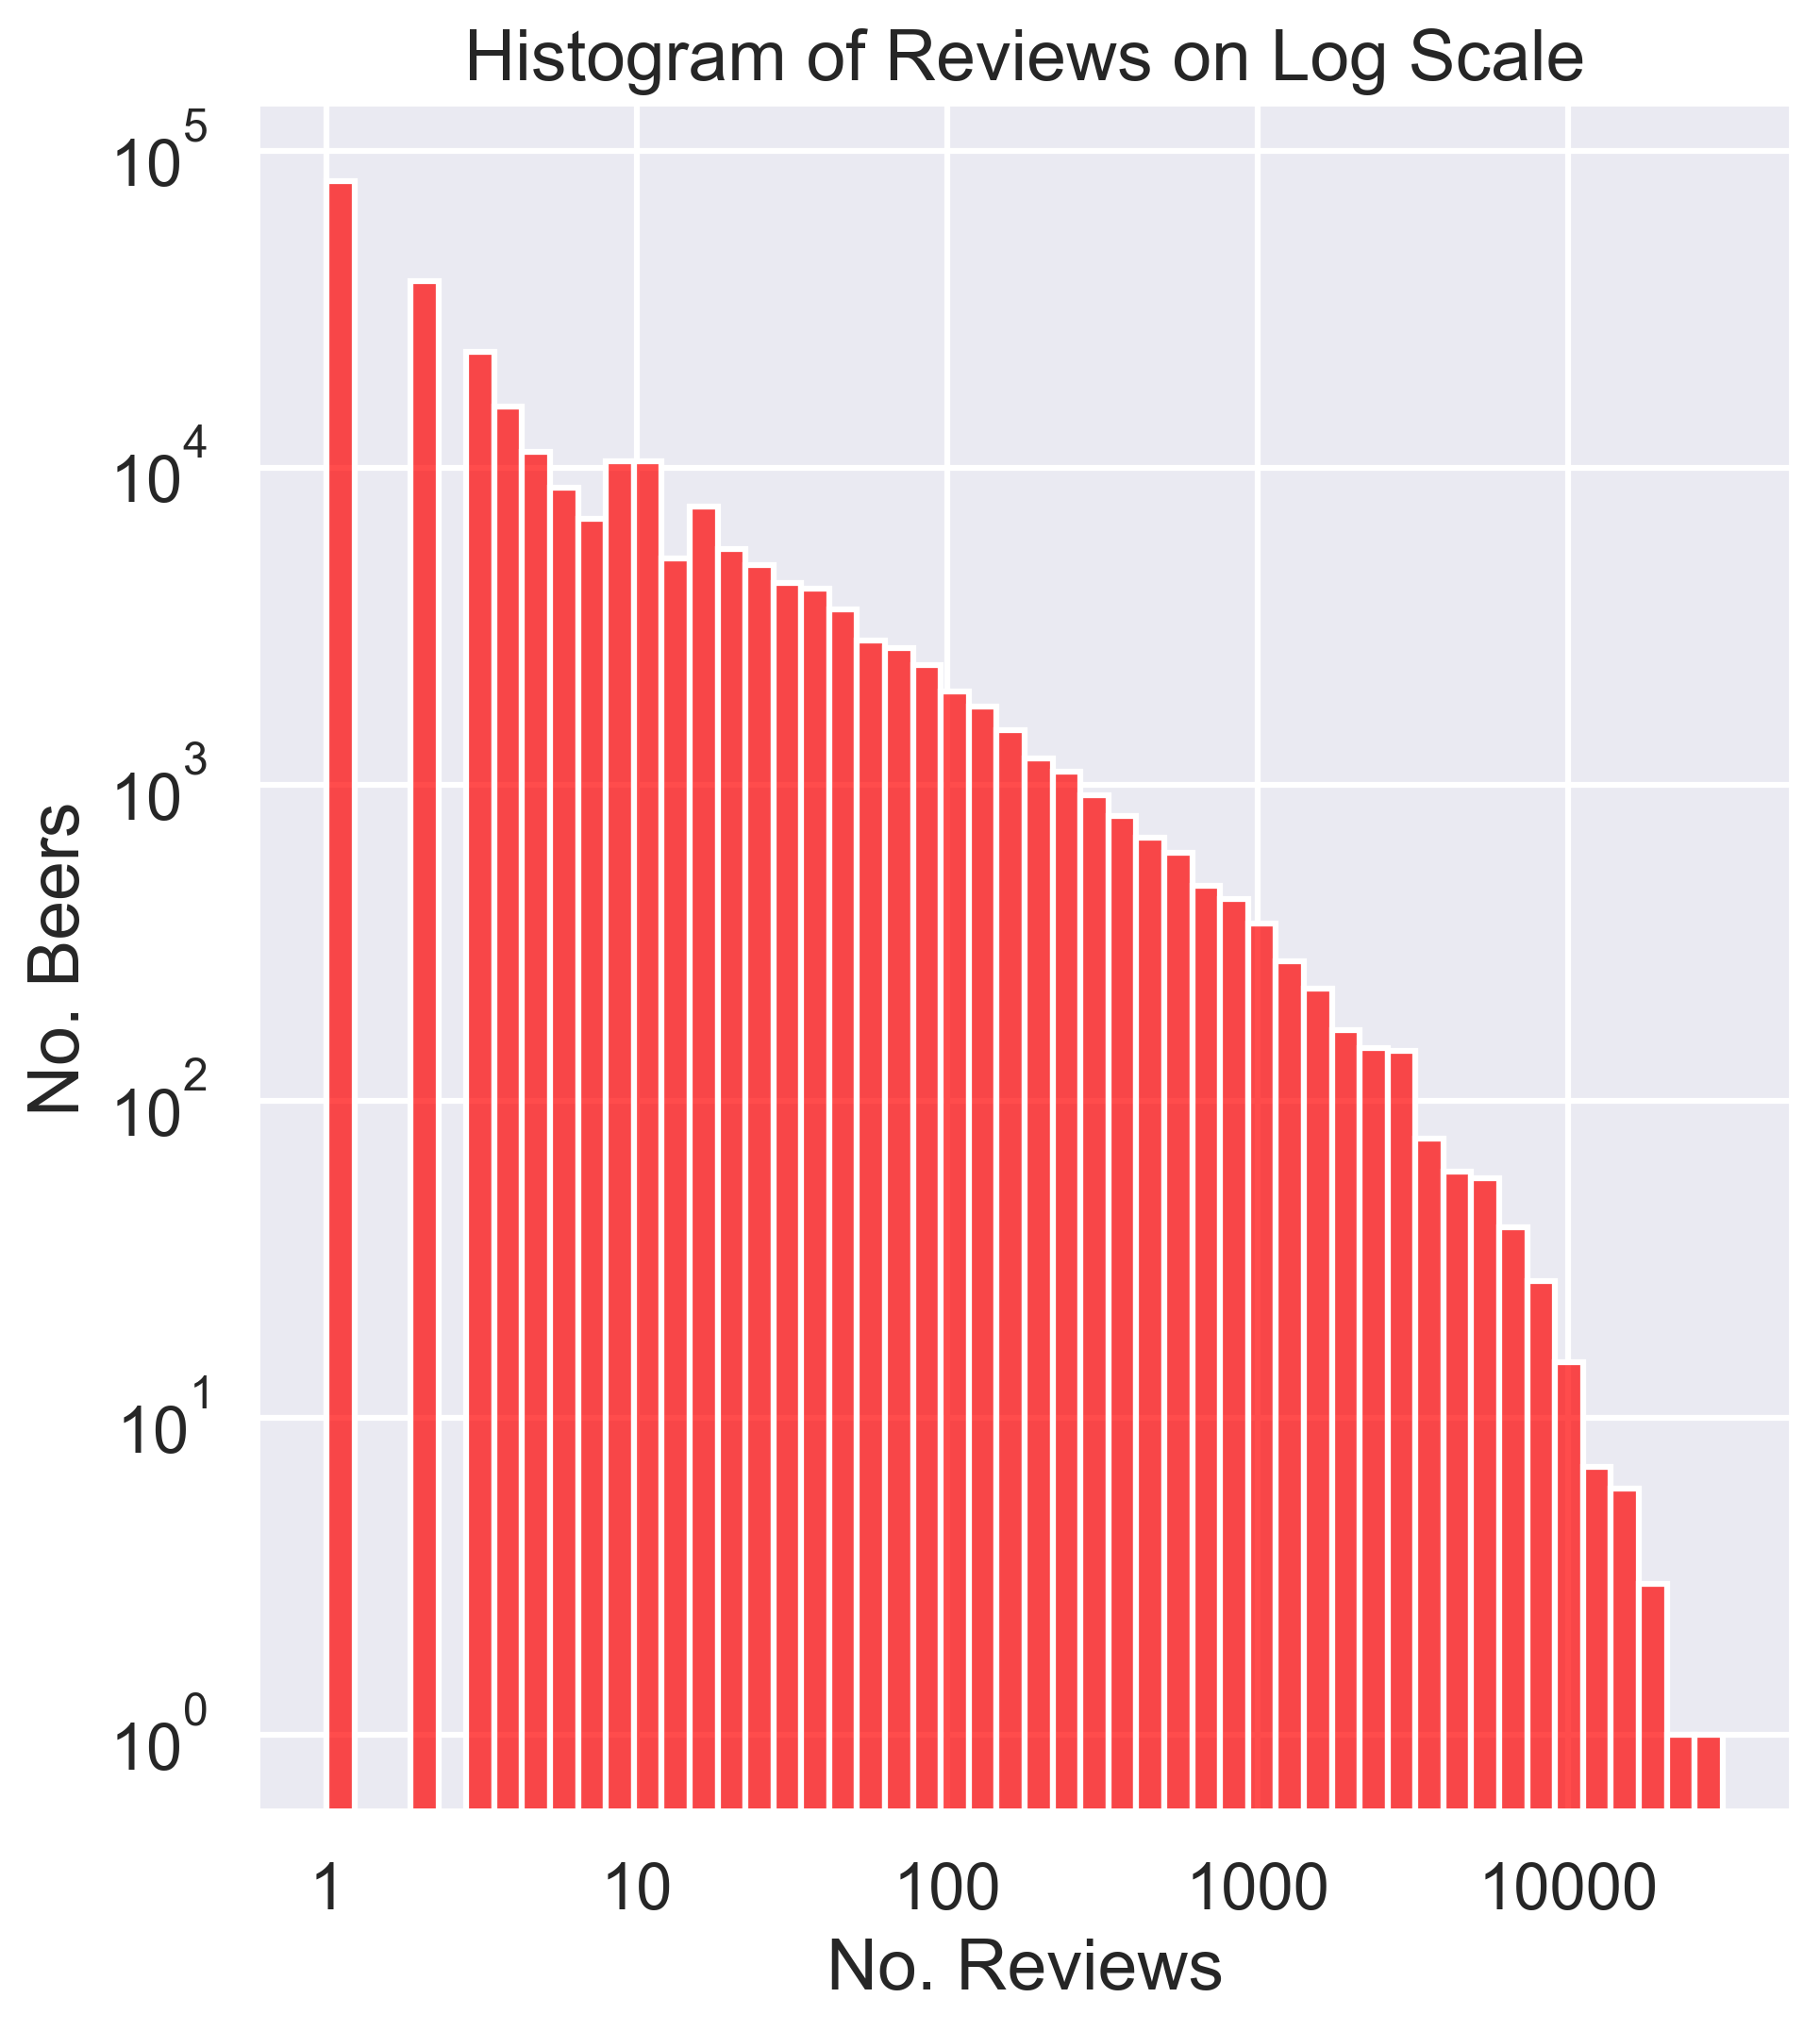

In [13]:
data=all_three_1.beer_name.value_counts()
sns.set_context('talk')
sns.set_style('darkgrid')

import matplotlib as mpl

#This plots the hist w/out kde
ax = plt.subplots(figsize=(7,8), dpi= 300)
ax = sns.histplot(data, bins = 50, kde=False, color= 'red', alpha=.7, log_scale=(True, True))

#Labels
ax.set_xlabel('No. Reviews')
ax.set_ylabel('No. Beers')
ax.set_title('Histogram of Reviews on Log Scale');

ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1,10, 100, 1000, 10000]);
#ax.set_yticks([1,10, 100, 1000, 10000, 100000]);
#plt.savefig('Review_Counts_3_3.png')


In [14]:
grouped_beers = all_three_1.groupby('beer_name')

In [15]:
grouped_beers.count().sort_values(by='username', ascending = False).quantile(np.arange(0,1,.05))

,username,look,smell,taste,feel,overall,score,brewery_name,style
0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.35,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.40,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.45,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [16]:
grouped_beers.mean().sort_values(by= 'score', ascending=False).quantile(np.arange(0,1,.05))

,look,smell,taste,feel,overall,score
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
0.05,0.000000,0.000000,0.000000,0.000000,0.000000,2.940000
0.10,0.000000,0.000000,0.000000,0.000000,0.000000,3.223333
0.15,0.000000,0.000000,0.000000,0.000000,0.000000,3.375000
0.20,0.000000,0.000000,0.000000,0.000000,0.000000,3.490000
0.25,0.000000,0.000000,0.000000,0.000000,0.000000,3.546429
0.30,0.000000,0.000000,0.000000,0.000000,0.000000,3.615809
0.35,0.000000,0.000000,0.000000,0.000000,0.000000,3.675000
0.40,0.000000,0.000000,0.000000,0.000000,0.000000,3.730000
0.45,0.000000,0.000000,0.000000,0.000000,0.000000,3.760596


In [30]:
avg_score= grouped_beers.mean()
#beers with average rating less than 4.0 are not worth recommending, and 
#i wanted to save on computational power

below_avg = avg_score['score'] < 4.0
below_avg_count = len(avg_score[below_avg])

print('{} beers have an average score below 4.0'.format(below_avg_count))
print('A 4.0 avg score puts the beer within the bottom 70th%-tile')

182227 beers have an average score below 4.0
A 4.0 avg score puts the beer within the bottom 70th%-tile


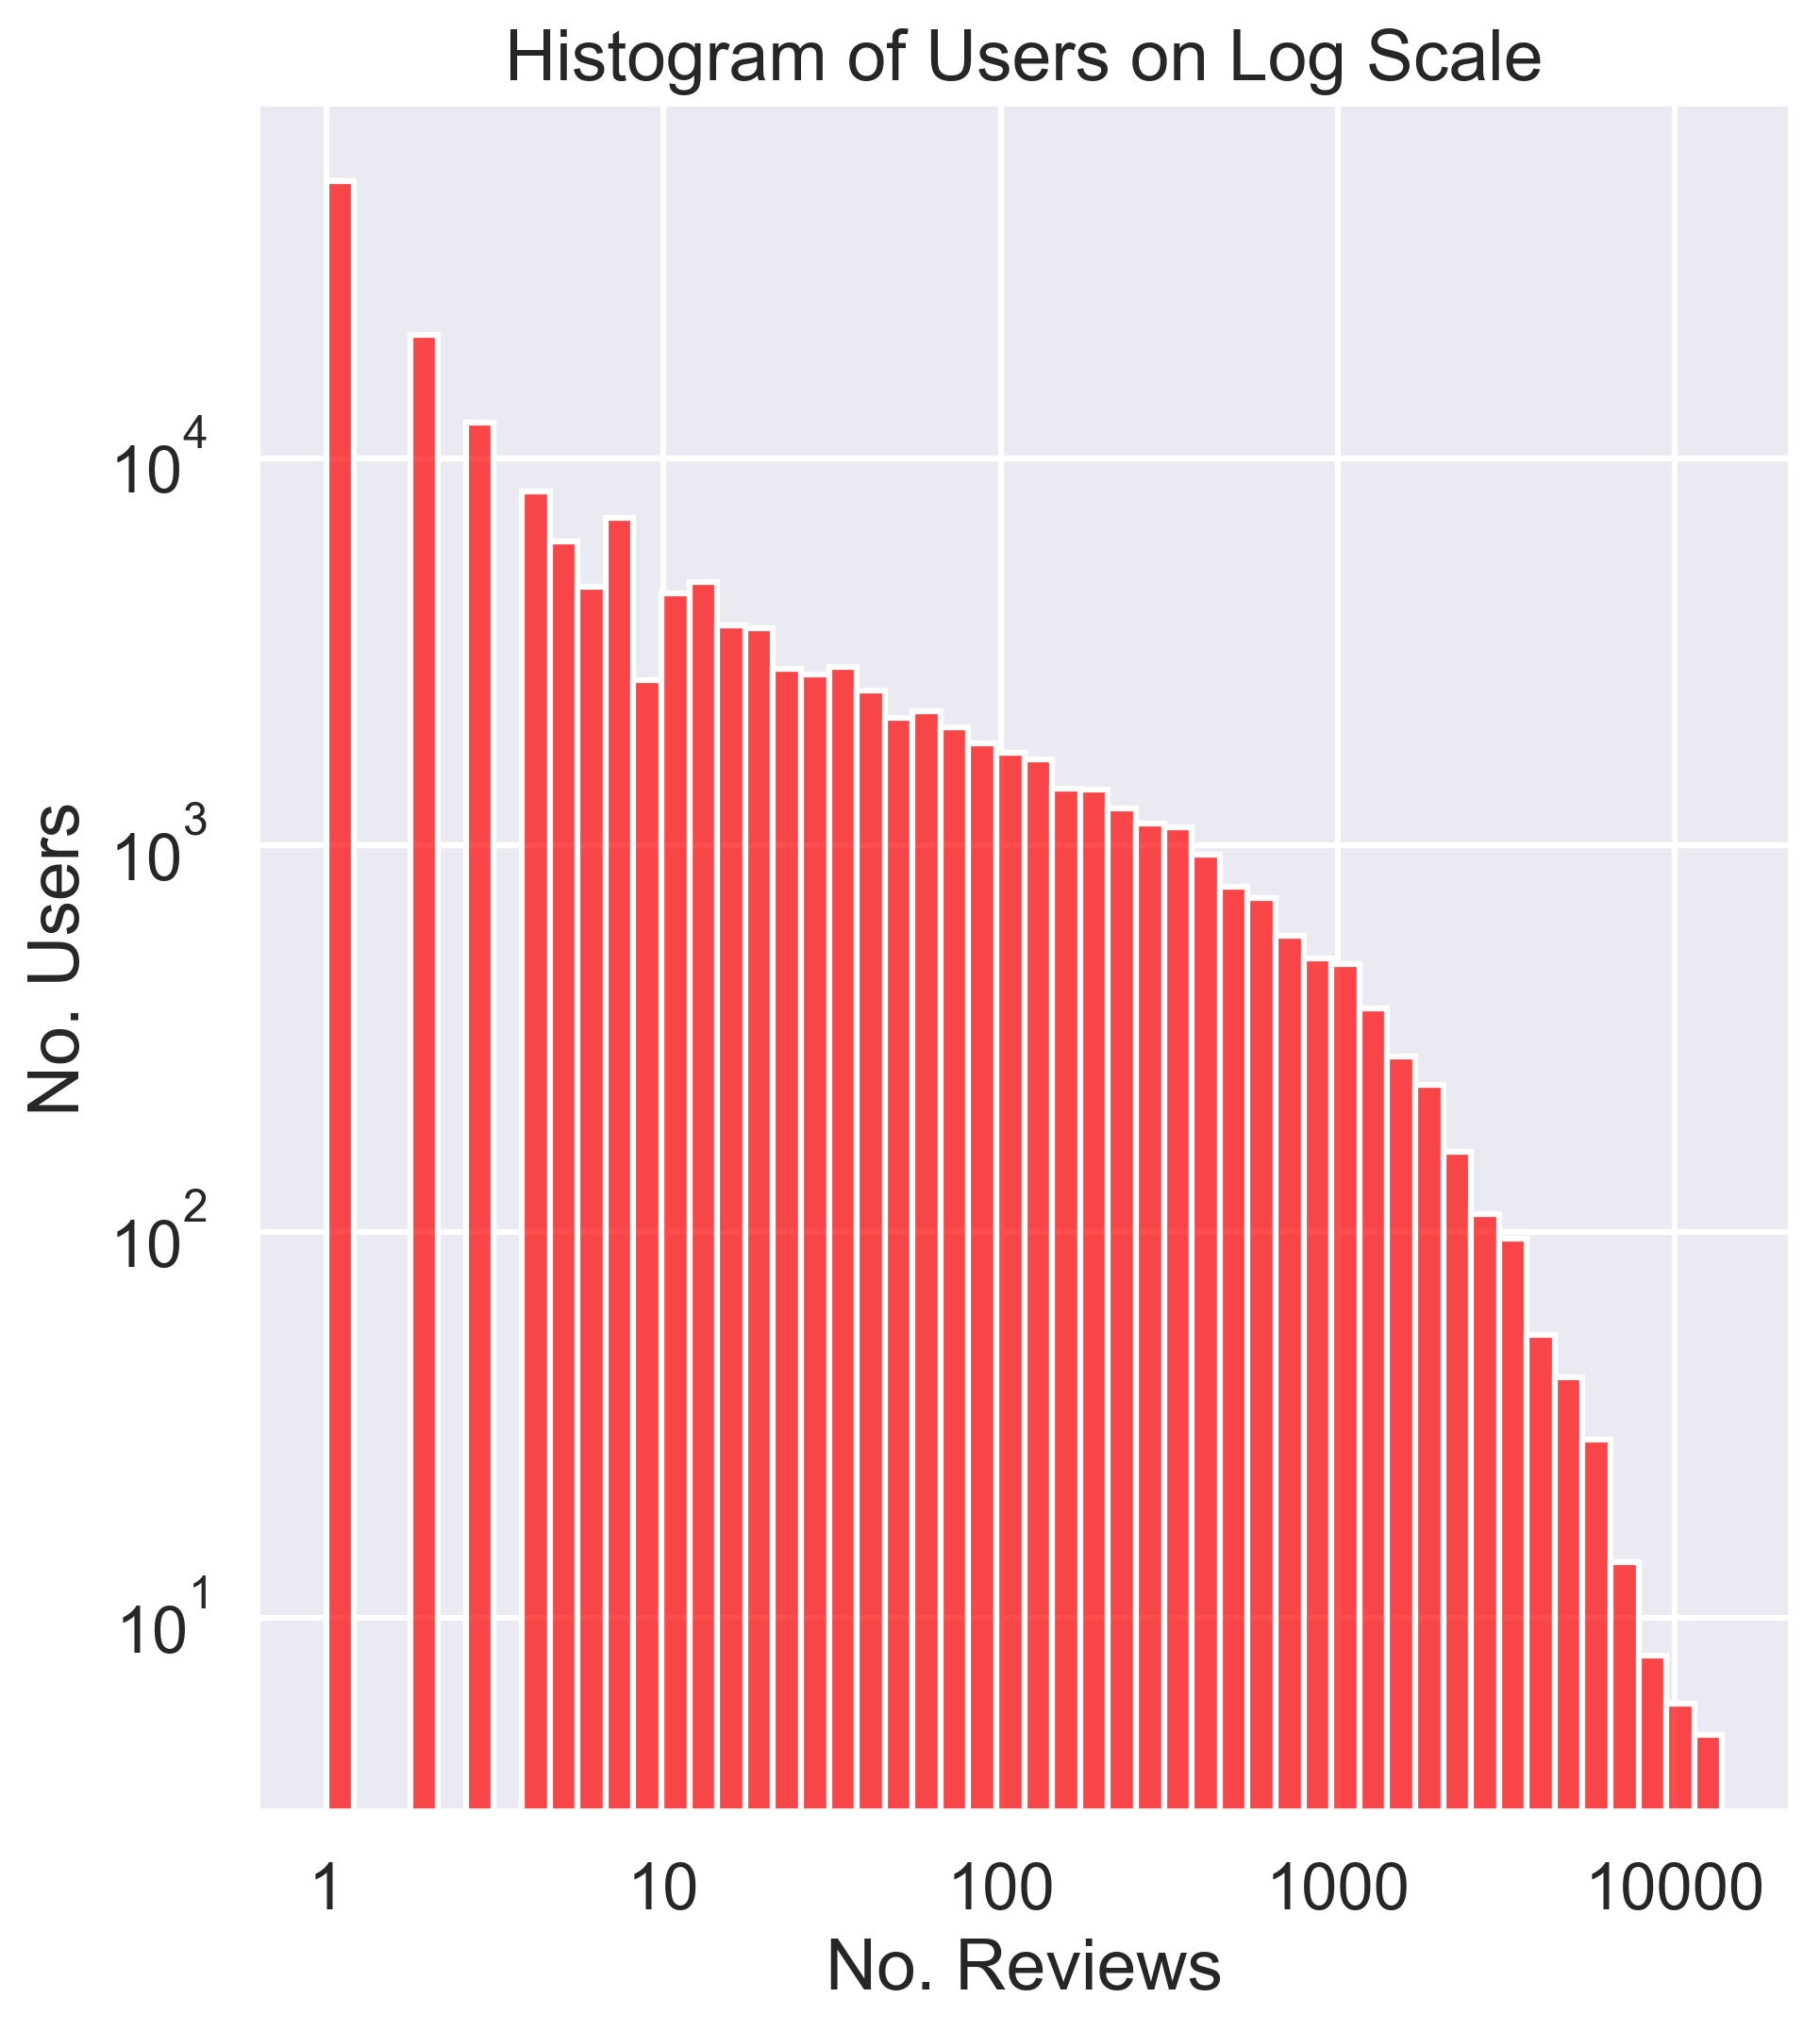

In [31]:
data2=all_three_1.username.value_counts()

plt.figure( figsize= (7,8), dpi=300)
sns.set_style('darkgrid')
sns.set_context('talk')
ax2 = sns.histplot(data2, bins = 50, kde=False, color= 'red', alpha=.7, log_scale=(True, True))

ax2.set_xlabel('No. Reviews')
ax2.set_ylabel('No. Users')
ax2.set_title('Histogram of Users on Log Scale')

ax2.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax2.set_xticks([1,10, 100, 1000, 10000]);
#ax2.set_yticks([1,10, 100, 1000, 10000]);

#plt.savefig('User_counts_3_2.png')

In [32]:
grouped_users= all_three_1.groupby('username')
grouped_users.head()

,username,look,smell,taste,feel,overall,score,beer_name,brewery_name,style
0,Jason,3.5,4.0,4.0,4.5,4.0,4.02,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
1,Morris729,4.0,3.5,4.0,4.0,4.0,3.88,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
2,MAB,4.0,4.5,4.5,4.0,4.5,4.42,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA
3,allengarvin,3.5,3.5,3.5,4.0,3.5,3.55,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
4,bditty187,4.0,3.0,3.0,3.5,3.5,3.21,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout
...,...,...,...,...,...,...,...,...,...,...
9072478,JMBurke,0.0,0.0,0.0,0.0,0.0,4.98,Erotolupulinophobia,Tuned Up Brewing Company,New England IPA
9072541,austincollins,0.0,0.0,0.0,0.0,0.0,5.00,Mel's Everyday Beer,Mel's Brewing Co,American Lager
9072707,Nachtraaf,0.0,0.0,0.0,0.0,0.0,3.68,Nachtraaf Speciale-Amber,Nachtraaf Brouwers,Belgian Pale Ale
9072754,IVBRW,0.0,0.0,0.0,0.0,0.0,4.90,Bulldog,Calexico Brewing Company,English Brown Ale


In [33]:
grouped_users_count = grouped_users.count()

counts = [1,2,3,4,5,10,15,20]
for ct in counts:
    num_users = grouped_users_count[grouped_users_count['score'] <= ct].count()[0]
    print('{} users rated {} or fewer beers'.format(num_users, ct))
print('\n')
print('Total Unique Users in this dataset: {}'.format(len(all_three_1.username.unique())))

52181 users rated 1 or fewer beers
73066 users rated 2 or fewer beers
85405 users rated 3 or fewer beers
93620 users rated 4 or fewer beers
99708 users rated 5 or fewer beers
116396 users rated 10 or fewer beers
124641 users rated 15 or fewer beers
129740 users rated 20 or fewer beers


Total Unique Users in this dataset: 164933


In [34]:
subpar_beers_list= list(avg_score[below_avg].index)

ratings_count = grouped_beers.count()

#Here i'm setting beers that have ratings counts less than 20 to be called low amount of ratings

low_ratings_count = ratings_count[ratings_count['score'] < 20]

low_ratings_list = list(low_ratings_count.index)


In [35]:
unique_subpar_beers = set(subpar_beers_list)
unique_low_ratings_beers = set(low_ratings_list)
overlap = unique_subpar_beers.intersection(unique_low_ratings_beers)
print('Number of beers in bottom 20% of avg rating: {}'.format(len(unique_subpar_beers)))
print('Number of beers in bottom 20% of review counts: {}'.format(len(unique_low_ratings_beers)))
print('Number of beers in both categories: {}'.format(len(overlap)))

Number of beers in bottom 20% of avg rating: 182227
Number of beers in bottom 20% of review counts: 219894
Number of beers in both categories: 153558


In [36]:
#Here the beers that are in the bottom of both categories are removed
df1 = all_three_1[~all_three_1.beer_name.isin(subpar_beers_list)]
df2 = df1[~df1.beer_name.isin(low_ratings_list)]
all_three_2 = copy.deepcopy(df2)


In [37]:
all_three_2.head()

,username,look,smell,taste,feel,overall,score,beer_name,brewery_name,style
13052,Michelle68Bressler,0.0,0.0,0.0,0.00,0.00,4.50,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
13053,CalgaryFMC,3.5,3.5,4.0,3.75,3.75,3.78,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
13054,MaddDogg84,0.0,0.0,0.0,0.00,0.00,5.00,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
13055,BillRoth,0.0,0.0,0.0,0.00,0.00,4.00,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
13056,dbaker61,0.0,0.0,0.0,0.00,0.00,3.75,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout


In [38]:
all_three_3 = all_three_2.reset_index()
all_three_3 = all_three_3.drop(columns=['index', 'look','smell','taste', 'feel', 'overall'],axis=1)
all_three_3.head()

,username,score,beer_name,brewery_name,style
0,Michelle68Bressler,4.50,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
1,CalgaryFMC,3.78,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
2,MaddDogg84,5.00,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
3,BillRoth,4.00,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout
4,dbaker61,3.75,Mackeson Triple XXX Stout,Whitbread PLC,English Sweet / Milk Stout


In [39]:
print('Original number of unique beers: {}'.format(len(all_three_1.beer_name.unique())))

print('Revised number of unique beers: {}'.format(len(all_three_2.beer_name.unique())))

Original number of unique beers: 261837
Revised number of unique beers: 13274


In [40]:
#creating a new beerID for each beer
grouped_name = all_three_3.groupby('beer_name')
temp_df = grouped_name.count()
temp_df_idx = pd.DataFrame(temp_df.index)

temp_df_idx['beerID'] = temp_df_idx.index
dict_df = temp_df_idx[['beerID', 'beer_name']]

desc_dict = dict_df.set_index('beer_name').to_dict()
new_dict = desc_dict['beerID']

all_three_3['beerID']= all_three_3.beer_name.map(new_dict)

#creating a new userID for each user
grouped_user = all_three_3.groupby('username')

temp_df_user = grouped_user.count()
temp_df_user_idx = pd.DataFrame(temp_df_user.index)

temp_df_user_idx['userID'] = temp_df_user_idx.index
dict_df_user = temp_df_user_idx[['userID', 'username']]

desc_dict_user = dict_df_user.set_index('username').to_dict()
new_dict_user = desc_dict_user['userID']

all_three_3['userID'] = all_three_3.username.map(new_dict_user)



In [41]:
#top 50 most rated beers
grouped_beer_names = all_three_3.groupby('beer_name')
print('These are the top 50 beers with the most ratings by username')
most_rate_50 =grouped_beer_names.count().sort_values(by='username', ascending= False)[0:50].index.tolist()
most_rate_50

These are the top 50 beers with the most ratings by username


['Imperial Stout',
 'Breakfast Stout',
 '90 Minute IPA',
 'Pliny The Elder',
 'Two Hearted Ale',
 'Sculpin IPA',
 'Heady Topper',
 'Hopslam Ale',
 'KBS (Kentucky Breakfast Stout)',
 'Bourbon County Brand Stout',
 'Old Rasputin',
 'Sierra Nevada Pale Ale',
 'Torpedo Extra IPA',
 'Enjoy By IPA',
 'Ruination IPA',
 '60 Minute IPA',
 'Arrogant Bastard Ale',
 'Zombie Dust',
 'Celebration Fresh Hop IPA',
 'Lagunitas Sucks',
 'La Fin Du Monde',
 'Ten FIDY',
 'Abt 12',
 'Trappistes Rochefort 10',
 "A Little Sumpin' Sumpin' Ale",
 'Imperial Russian Stout',
 'Centennial IPA',
 'Nugget Nectar',
 'Weihenstephaner Hefeweissbier',
 'Backwoods Bastard',
 '120 Minute IPA',
 'Jai Alai IPA',
 'West Coast IPA',
 'Harvest Ale',
 'Duvel Belgian Golden Ale',
 'Chimay Grande Réserve (Blue)',
 'Hop Stoopid',
 'Racer 5 India Pale Ale',
 'Dirty Bastard',
 'Pumking',
 'Bigfoot Barleywine-Style Ale',
 'Double Jack',
 'HopDevil India Pale Ale',
 'The Abyss',
 'Bourbon County Brand Coffee Stout',
 'Victory At Sea I

In [42]:
#top 50 highest rated beers
print('These are the top 50 beers with the highest ratings')
top_rate_50 = grouped_beer_names.mean().sort_values(by='score', ascending = False)[0:50].index.tolist()
top_rate_50

These are the top 50 beers with the highest ratings


['2 Candles',
 'Vanilla Bean Assassin',
 'One Candle',
 '3 Candles',
 'Kentucky Brunch Brand Stout',
 'Rare Bourbon County Brand Stout (2010)',
 'Derivation Blend #2 (Ugandan Vanilla Bean)',
 'Good Morning',
 'Pilot Series Passionfruit Dragonfruit Berliner',
 'Pilot Series Miami Madness Berliner',
 'Derivation Blend #5 (Rum Barrel W/ Sump Colombian Coffee + Ugandan Vanilla)',
 'R&D Sour Fruit (Very Sour Blackberry)',
 'Hannahpu - Mayan Chocolate Doughnut Hunahpu Imperial Stout',
 'Anabasis',
 'Bake Kujira - Cali Brandy Big Poppa',
 'Derivation Blend #6 (Cinnamon, Cocoa Nibs And Ugandan Vanilla)',
 'Bourbon County Brand Neapolitan Stout',
 'Miles To Go Before I Sleep',
 'Double Barrel Hunahpoopoo',
 'Barrel-Aged Abraxas',
 'Black Magick - Pappy Van Winkle',
 'Bczar Beans',
 'King Julius',
 'Drie Fonteinen Zenne Y Frontera',
 'Marshmallow Handjee',
 'The Curious No. 6',
 "Armand'4 Oude Geuze Lente (Spring)",
 'Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow',
 'King JJJuli

In [177]:
all_three_3[all_three_3.beer_name=='Heady Topper' ].tail(3)
#all_three_3[all_three_3.userID==22662]
#brad.iloc[140:160]
#hanzo.iloc[220:240]
#eddie.iloc[0:60]
#gwalk.head(20)
#madd.iloc[60:80]

,username,score,beer_name,brewery_name,style,beerID,userID
915288,Soloveitchik,4.67,Heady Topper,The Alchemist Brewery and Visitors Center,New England IPA,5745,55539
915289,Leffo,5.00,Heady Topper,The Alchemist Brewery and Visitors Center,New England IPA,5745,36902
915290,liverust,5.00,Heady Topper,The Alchemist Brewery and Visitors Center,New England IPA,5745,93516


In [46]:
def read_item_names():
    file_name = dict_df
    raw_id_to_name = {}
    name_to_raw_id = {}
    
    #there were 13274 unique beers after removing those w/ low rating and review counts
    unique_beers= len(all_three_3.beer_name.unique())

    
    for i in range(unique_beers):
        line=file_name.iloc[i]
        raw_id_to_name[line[0]] = line[1]
        name_to_raw_id[line[1]] = line[0]
        

    return raw_id_to_name, name_to_raw_id

In [47]:
#this one uses KNN Baseline with cosine distance

def get_recommendation(beer_name, k_):
    '''
    Input a beer and get k recommendations 
       that are based on similarity
       
       Input: string, integer
       Output: string
    '''
   

    output = []
    beer= str(beer_name)
    
    #Read the maps raw id --> beer name and vice versa
    raw_id_to_name, name_to_raw_id = read_item_names()
    #get the inner id of the beer
    beer_input_raw_id = name_to_raw_id[beer]
    beer_input_inner_id = algo.trainset.to_inner_iid(beer_input_raw_id)
    
    K= k_
    
    #get the inner ids of the nearest neighbors of the beer
    beer_input_near_neigh = algo.get_neighbors(beer_input_inner_id, k=K)
    
    #changes the inner ids of the neighbors into names
    beer_input_near_neigh = (algo.trainset.to_raw_iid(inner_id)
                            for inner_id in beer_input_near_neigh)
    beer_input_near_neigh = (raw_id_to_name[rid]
                            for rid in beer_input_near_neigh)
    
    for beer_ in beer_input_near_neigh:
        output.append(beer_)
        
    return output


In [48]:
#Train the algorithm to compute the similarities between items (item-item collaborative filtering)

#this is knn baseline, but with Cosine distance to measure
reader= Reader(rating_scale=(1,5))
data= Dataset.load_from_df(all_three_3[['userID', 'beerID', 'score']],reader)
trainset, testset = train_test_split(data, test_size = .25)

trainset = data.build_full_trainset()
sim_options = {'name':'cosine', 'user_based': False}
algo= KNNBaseline(sim_options = sim_options)
algo.fit(trainset)

predictions = algo.test(testset)
accuracy.rmse(predictions)
#accuracy.mse(predictions)
#accuracy.mae(predictions)
#this only works with the testset


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3156


0.31557673558918925

In [49]:
#This one uses KNN baseline with pearson-baseline

def get_recommendation1(beer_name, k_):
    '''Input a beer and get k recommendations 
       that are based on similarity
       
       Input: string, integer
       Output: string
    '''
    output = []
    beer= str(beer_name)
    
    #Read the maps raw id --> beer name and vice versa
    raw_id_to_name, name_to_raw_id = read_item_names()
    #get the inner id of the beer
    beer_input_raw_id = name_to_raw_id[beer]
    beer_input_inner_id = algo1.trainset.to_inner_iid(beer_input_raw_id)
    
    K= k_
    
    #get the inner ids of the nearest neighbors of the beer
    beer_input_near_neigh = algo1.get_neighbors(beer_input_inner_id, k=K)
    
    #changes the inner ids of the neighbors into names
    beer_input_near_neigh = (algo1.trainset.to_raw_iid(inner_id)
                            for inner_id in beer_input_near_neigh)
    beer_input_near_neigh = (raw_id_to_name[rid]
                            for rid in beer_input_near_neigh)
    
    for beer_ in beer_input_near_neigh:
        output.append(beer_)
        
    return output

In [50]:
#Train the algorithm to compute the similarities between items (item-item collaborative filtering)

#this uses Pearson-Baseline to measure
reader= Reader(rating_scale=(1,5))
data= Dataset.load_from_df(all_three_3[['userID', 'beerID', 'score']],reader)
trainset, testset = train_test_split(data, test_size = .25)
#might have to put the above back in
trainset = data.build_full_trainset()
#testset = trainset.build_anti_testset()
sim_options = {'name':'pearson_baseline', 'user_based': False}
algo1= KNNBaseline(sim_options = sim_options)
algo1.fit(trainset)

predictions1 = algo1.test(testset)
accuracy.rmse(predictions1)
#accuracy.mse(predictions1)
#accuracy.mae(predictions1)
#this only works with the testset

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2017


0.20169976792550987

In [51]:
# #This one uses KNN baseline with MSD
# '''
# def get_recommendation2(beer_name, k_):
# '''

# '''
#        Input a beer and get k recommendations 
#        that are based on similarity
       
#        Input: string, integer
#        Output: string
# '''
    
# '''
#     output = []
#     beer= str(beer_name)
    
#     #Read the maps raw id --> beer name and vice versa
#     raw_id_to_name, name_to_raw_id = read_item_names()
#     #get the inner id of the beer
#     beer_input_raw_id = name_to_raw_id[beer]
#     beer_input_inner_id = algo2.trainset.to_inner_iid(beer_input_raw_id)
    
#     K= k_
    
#     #get the inner ids of the nearest neighbors of the beer
#     beer_input_near_neigh = algo2.get_neighbors(beer_input_inner_id, k=K)
    
#     #changes the inner ids of the neighbors into names
#     beer_input_near_neigh = (algo2.trainset.to_raw_iid(inner_id)
#                             for inner_id in beer_input_near_neigh)
#     beer_input_near_neigh = (raw_id_to_name[rid]
#                             for rid in beer_input_near_neigh)
    
#     for beer_ in beer_input_near_neigh:
#         output.append(beer_)
        
#     return output
# '''

In [52]:
# #this uses MSD to measure
# '''
# reader= Reader(rating_scale=(1,5))
# data= Dataset.load_from_df(all_three_2[['userID', 'beerID', 'score']],reader)
# trainset, testset = train_test_split(data, test_size = .25)
# #might have to put the above back in

# trainset = data.build_full_trainset()
# sim_options = {'name':'msd', 'user_based': False}
# algo2= KNNBaseline(sim_options = sim_options)
# algo2.fit(trainset)

# predictions2 = algo2.test(testset)
# accuracy.rmse(predictions2)
# #accuracy.mse(predictions2)
# #accuracy.mae(predictions2)
# # this only works with the testset
# '''

In [53]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [54]:
reader= Reader(rating_scale=(1,5))
# First train an knn baseline algorithm on the beer dataset.
data = Dataset.load_from_df(all_three_3[['userID', 'beerID', 'score']], reader)
trainset1 = data.build_full_trainset()
sim_options= {'name':'pearson_baseline', 'user_based': False}
algoPB = KNNBaseline(sim_options=sim_options)
algoPB.fit(trainset1)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset1.build_anti_testset()
# predictionsPB = algoPB.test(testset)

# top_n = get_top_n(predictionsPB, n=5)
#print(top_n)
# Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# #This one uses KNN basic

# def get_recommendation3(beer_name, k_):
#     '''Input a beer and get k recommendations 
#        that are based on similarity
       
#        Input: string, integer
#        Output: string
#     '''
#     output = []
#     beer= str(beer_name)
    
#     #Read the maps raw id --> beer name and vice versa
#     raw_id_to_name, name_to_raw_id = read_item_names()
#     #get the inner id of the beer
#     beer_input_raw_id = name_to_raw_id[beer]
#     beer_input_inner_id = algo3.trainset.to_inner_iid(beer_input_raw_id)
    
#     K= k_
    
#     #get the inner ids of the nearest neighbors of the beer
#     beer_input_near_neigh = algo3.get_neighbors(beer_input_inner_id, k=K)
    
#     #changes the inner ids of the neighbors into names
#     beer_input_near_neigh = (algo3.trainset.to_raw_iid(inner_id)
#                             for inner_id in beer_input_near_neigh)
#     beer_input_near_neigh = (raw_id_to_name[rid]
#                             for rid in beer_input_near_neigh)
    
#     for beer_ in beer_input_near_neigh:
#         output.append(beer_)
        
#     return output

In [ ]:
# #this uses KNN Basic to measure

# reader= Reader(rating_scale=(1,5))
# data= Dataset.load_from_df(all_three_2[['userID', 'beerID', 'score']],reader)
# trainset, testset = train_test_split(data, test_size = .25)
# #might have to put the above back in

# trainset = data.build_full_trainset()
# #sim_options = {'name':'pearson', 'user_based': False}
# algo3= KNNBasic() #(sim_options = sim_options)
# algo3.fit(trainset)

# predictions3 = algo3.test(testset)
# accuracy.rmse(predictions3)
# accuracy.mse(predictions3)
# accuracy.mae(predictions3)
# #this only works with the testset

In [ ]:
#This would save the fit results

# with open('algo.pkl_1', 'wb') as f:
#     pickle.dump(algo, f)

In [ ]:
#This would open up the saved file

#with open('algo.pkl', 'rb') as m:
#     algo_model = pickle.load(m)

# #algo_model.test(testset)

In [56]:
def ratings_matrix():
    """ Sets initial ratings matrix with items ranked 1-5. 
        
        Rows are users, columns are beers. 
        Fill unrated items with 0 values.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        2d numpy array of type float
    """ 
    return np.array([[4.65, 5.00, 5.50, 4.50, 5.00],
                     [5.00, 4.60, 5.00, 4.00, 0.00],
                     [4.25, 4.50, 4.00, 4.25, 4.25],
                     [4.32, 0.00, 0.00, 4.69, 4.69],
                     [0.00, 4.28, 3.96, 0.00, 4.17]]).astype(float)

In [150]:
def sim_euclidean(u, v):
    """ Finds euclidean similarity between two vectors 
        
        Parameters
        ----------
        u : 1d np.array
        v : 1d np.array
        
        Returns
        -------
        float
    """ 
    return 1 / (1 + euclidean(u, v))

def sim_cosine(u, v):
    """ Finds cosine similarity between two vectors 
        
        Parameters
        ----------
        u : 1d np.array
        v : 1d np.array
        
        Returns
        -------
        float
    """
    costheta = np.dot(u, v)/(np.linalg.norm(u) * np.linalg.norm(v))
    return 0.5 + 0.5 * costheta

def sim_pearson(u, v):
    '''
        Finds the Pearson correlation between two vectors
    
        Paramaters
        ___________
    
        u : 1d np.array
        v : 1d np.array
    
        returns
        _______
        float
    '''

    u = np.array(u)
    v = np.array(v)
    u_mean = u.mean()
    v_mean = v.mean()    
    u_less_mean = u - u_mean
    v_less_mean = v - v_mean
    numerator = np.sum(u * v)
    denominator = np.sqrt(
        np.sum(u**2) * np.sum(v**2)
    )
    return numerator / denominator
    

In [151]:
def rating_collab(R, user, sim_func, item_ur):
    """User rating for unrated item using item-item similarity.

       Parameters
       ----------
       R : 2d numpy array
           ratings matrix where rows are users, columns are items
       user : int
           the user of interest (row in R)
       item_ur : int
           the user's unrated item of interest (col in R)
       sim_func : function
           similarity function to quantify similarity of items
           
       Returns
       -------
       float
          weighted rating for item based on item-item similarity
    """        
    n = R.shape[1] # number of columns (items) in R array
    sim_total = 0.0 # summed similarity of items to item of interest
    rat_sim_prod_total = 0.0 # summed rating * similarity for all items
    where_item_ur_rated = R[:,item_ur] > 0 # where the item of interest was rated
    for j in range(n): # for all the items
        rating = R[user, j] # get the user rating for that item
        if rating == 0:
            continue # not rated so it will not factor in rating
        where_item_rated = R[:, j] > 0
        where_both_rated = np.logical_and(where_item_ur_rated, where_item_rated)
        rows_both_rated = np.nonzero(where_both_rated)[0] 
        if len(rows_both_rated) == 0:
            similarity = 0 # no rows where they are both rated
        else:
            u = R[rows_both_rated, item_ur] # masked vector
            v = R[rows_both_rated, j] # masked vector
            similarity = sim_func(u, v) # find similarity between vectors
        sim_total += similarity
        #print(f'{sim_total}')# denominator of weighted rating
        rat_sim_prod_total += rating * similarity # numerator of weighted rating
    if sim_total == 0:
        return 0
    else:
        weighted_rating = rat_sim_prod_total / sim_total  # weighted rating
        return weighted_rating

In [152]:
R = ratings_matrix()
print(R)

[[4.65 5.   5.5  4.5  5.  ]
 [5.   4.6  5.   4.   0.  ]
 [4.25 4.5  4.   4.25 4.25]
 [4.32 0.   0.   4.69 4.69]
 [0.   4.28 3.96 0.   4.17]]


In [153]:
from scipy import stats
from scipy.spatial.distance import euclidean #change to pearson, not euclidean
import numpy as np
from numpy import cov
from scipy.stats import pearson3

In [154]:
# demo some part of function
usr = 1    # user
itm_ur = 4  # unrated item of interest
itm_cu = 3 # current item

ratings_usr = R[usr,:]
print(f"User {usr} ratings:")
print(ratings_usr)

ratings_cu = R[:,itm_cu]
print(f"\nCurrent item {itm_cu}")
print(ratings_cu)

where_item_ur_rated = R[:,itm_ur] > 0
print(f"\nRows where unrated item {itm_ur} was rated")
print(where_item_ur_rated)

where_item_cu_rated = R[:, itm_cu] > 0
print(f"\nRows where current item {itm_cu} was rated")
print(where_item_cu_rated)

where_both_rated = np.logical_and(where_item_ur_rated, where_item_cu_rated)
rows_both_rated = np.nonzero(where_both_rated)[0] 
print(f"\nRows where both unrated and current item rated")
print(rows_both_rated)

# make vectors
u = R[rows_both_rated, itm_ur]  # masked vector
v = R[rows_both_rated, itm_cu]  # masked vector
# calculate similarity
similarity = sim_pearson(u, v)      # This needs to be changed to pearson form cosine, 
                                    #find similarity between vectors

print(f"\nu {u}")
print(f"v {v}")
print(f"Similarity: {similarity.round(4)}")

User 1 ratings:
[5.  4.6 5.  4.  0. ]

Current item 3
[4.5  4.   4.25 4.69 0.  ]

Rows where unrated item 4 was rated
[ True False  True  True  True]

Rows where current item 3 was rated
[ True  True  True  True False]

Rows where both unrated and current item rated
[0 2 3]

u [5.   4.25 4.69]
v [4.5  4.25 4.69]
Similarity: 0.9987


In [155]:
# using pearson similarity
usr = 1
itm_ur = 4
rtng = rating_collab(R, user=usr, sim_func=sim_pearson, item_ur=itm_ur)

print("The predicted rating of user {} on item {} is {:0.2f}.".format(usr, itm_ur, rtng))

The predicted rating of user 1 on item 4 is 4.65.


In [156]:
# using cosine similarity
rtng = rating_collab(R, user=usr, sim_func=sim_cosine, item_ur=itm_ur)
print("The predicted rating of user {} on item {} is {:0.2f}.".format(usr, itm_ur, rtng))

The predicted rating of user 1 on item 4 is 4.65.


In [157]:
def find_unrated_items_per_user(R):
    """ Finds unrated items (columns) for each user 
        
        Parameters
        ----------
        R : 2d numpy array
           ratings matrix where rows are users, columns are items
        Returns
        -------
        dict where key = user (row) and values = list of ints (columns)
    """
    unrated = dict()
    for user in range(R.shape[0]):
        unrated_items = np.nonzero(R[user, :] == 0)[0]
        unrated[user] = unrated_items
    return unrated

In [158]:
def estimate_ratings(R, unrated, sim_func=sim_euclidean, est_method=rating_collab):
    """ Estimates the unrated items in the ratings matrix for each user 
        
        Parameters
        ----------
        R : 2d numpy array
           ratings matrix where rows are users, columns are items
        unrated: dict 
           key = user (row) and values = list of ints (columns)
        sim_func : function
           similarity function to quantify similarity of items
        est_method : function
           the function that will be used to estimate the ratings
        Returns
        -------
        R_est : 2d numpy array
           estimated ratings matrix where rows are users, columns are items
    """
    R_est = R.copy()
    for user, unrated_items in unrated.items():
        for unrated_item in unrated_items:
            R_est[user, unrated_item] = est_method(R, user, sim_func, unrated_item)
    return R_est

In [159]:
def recommend_n_items(R, user, n=3, sim_func=sim_pearson, est_method=rating_collab):
    """Recommends n previously unrated items to a user

       Parameters
       ----------
       R : 2d numpy array
           ratings matrix where rows are users, columns are items
       user : int
           the user of interest (row in R)
       sim_meas : function
           the similarity measure that will be used
       est_method : function
           the function that will be used to estimate the ratings
       Returns
       -------
       list of ints      
          sorted items (column indices) to recommend
    """     
    unrated_items = np.nonzero(R[user, :] == 0)[0]
    if len(unrated_items) == 0:
        return "Everything is rated."
    item_scores = []
    for item in unrated_items:
        estimated_score = est_method(R, user, sim_func, item)
        item_scores.append((item, estimated_score))
    return sorted(item_scores, key = lambda x: x[1], reverse=True)[:n]

In [160]:
R = ratings_matrix()
print("\nThe original ratings matrix:")
print(R.round(2))
unrated = find_unrated_items_per_user(R)
R_est = estimate_ratings(R, unrated, sim_func=sim_pearson, est_method=rating_collab)
print("\nThe ratings matrix filled in using item-item similarity:") 
R_est =R_est.round(2)
print(R_est)
#print("\nRecommendations:")

# for user in range(R.shape[0]):
#     recs = recommend_n_items(R, user, n=3, sim_func=pearsonr, est_method=rating_collab)
#     rec_str = ' and '.join(['item {0} {1:0.2f}'.format(rec[0], rec[0]) for rec in recs])
#     print(''.join(['User {0} should recommended '.format(user), rec_str, '.']))


The original ratings matrix:
[[4.65 5.   5.5  4.5  5.  ]
 [5.   4.6  5.   4.   0.  ]
 [4.25 4.5  4.   4.25 4.25]
 [4.32 0.   0.   4.69 4.69]
 [0.   4.28 3.96 0.   4.17]]

The ratings matrix filled in using item-item similarity:
[[4.65 5.   5.5  4.5  5.  ]
 [5.   4.6  5.   4.   4.65]
 [4.25 4.5  4.   4.25 4.25]
 [4.32 4.57 4.57 4.69 4.69]
 [4.14 4.28 3.96 4.14 4.17]]


In [162]:
print('The 20 nearest neighbors of Heady Topper are:')
print(get_recommendation('Heady Topper',20 ))
print(get_recommendation1('Heady Topper', 20))
#print(get_recommendation2('Heady Topper', 20))
#get_recommendation3('Heady Topper', 20) This was knn basic that was taking forever to run and kept crashing the program

The 20 nearest neighbors of Heady Topper are:
['Screaming Banshee Irish Cream Stout', 'Brett Zeste Saison', 'The Derailer', 'Torpor Porter', 'Citra Grove Dry Hopped Sour', 'Parade of Bones', 'Frucht: Guava', 'Behold!', 'Ichorous Imperial Stout', 'SuperNova', 'Holiday Triple Black Rye IPA (2014)', 'Barrel Project 17.03', 'Ganache', 'Art #14', 'Tiger Uppercut', 'IV Hazy Pale Ale', 'Onsight IPA #7', 'Olas Espaciales', 'Midnight Vorlauf Coffee Porter', 'Hop Of The Month: Mosaic IPA']
['DC Mountain Double IPA', 'Focal Banger', 'Et Tu Brut', 'Brigadeiro', 'Double Sunshine IPA', 'Big Doedish', 'Sip Of Sunshine', 'Crusher', 'Pliny The Elder', 'We Are All Infinite Energy Vibrating At The Same Frequency', 'Bright - Galaxy', 'Grass Fed Lettuce', 'Crispy Little', '7sue', 'King JJJuliusss', 'Flora Plum', 'Triple Sunshine IPA', 'Imperial Flanders Red Ale', 'Zombie Dust', 'Double Citra']


In [163]:
top_300_rated = all_three_3.groupby('beer_name').count().sort_values(by= 'username', ascending = False)[0:300].index.tolist()
top_300_rated = set(top_300_rated)

top_300_scores = all_three_3.groupby('beer_name').mean().sort_values(by='score', ascending = False)[0:300].index.tolist()
top_300_scores = set(top_300_scores)

heady= set(get_recommendation('Heady Topper', 20))
heady1= set(get_recommendation1('Heady Topper', 20))
#heady2 = set(get_recommendation2('Heady Topper', 50))

In [164]:
print(heady.intersection(top_300_rated))
print(heady.intersection(top_300_scores))

print(heady1.intersection(top_300_rated))
print(heady1.intersection(top_300_scores))

# print(heady2.intersection(top_300_rated))
# print(heady2.intersection(top_300_scores))

print(top_300_rated.intersection(top_300_scores))

set()
set()
{'Zombie Dust', 'Sip Of Sunshine', 'Focal Banger', 'Pliny The Elder'}
{'Pliny The Elder', 'King JJJuliusss', 'Double Sunshine IPA', 'Triple Sunshine IPA', 'Double Citra', 'Zombie Dust', 'Focal Banger', 'Flora Plum'}
{'Pliny The Elder', 'Bourbon County Brand Stout', 'Bourbon County Brand Coffee Stout', 'Abner', "Cantillon Fou' Foune", 'Heady Topper', 'Pliny The Younger', 'Green', 'Zombie Dust', 'Focal Banger', 'KBS (Kentucky Breakfast Stout)', 'Haze', 'Trappist Westvleteren 12 (XII)', 'CBS (Canadian Breakfast Stout)', 'Julius', 'Parabola'}


In [165]:
heady = set(get_recommendation('Heady Topper', 20))
heady1= set(get_recommendation1('Heady Topper', 20))
#heady2= set(get_recommendation2('Heady Topper', 20))
#heady3= set(get_recommendation3('Heady Topper', 20))
print('The 20 nearest neighbors of Heady Topper:')
print(heady)
print(heady1)
#print(heady2)
#heady3

The 20 nearest neighbors of Heady Topper:
{'The Derailer', 'Frucht: Guava', 'Brett Zeste Saison', 'Midnight Vorlauf Coffee Porter', 'Ganache', 'Olas Espaciales', 'Torpor Porter', 'Hop Of The Month: Mosaic IPA', 'Tiger Uppercut', 'Ichorous Imperial Stout', 'Onsight IPA #7', 'Citra Grove Dry Hopped Sour', 'Art #14', 'Holiday Triple Black Rye IPA (2014)', 'Barrel Project 17.03', 'Behold!', 'IV Hazy Pale Ale', 'Screaming Banshee Irish Cream Stout', 'SuperNova', 'Parade of Bones'}
{'King JJJuliusss', 'Big Doedish', 'Focal Banger', 'Brigadeiro', 'Zombie Dust', 'Grass Fed Lettuce', 'Pliny The Elder', 'Double Sunshine IPA', 'Crusher', 'DC Mountain Double IPA', '7sue', 'Bright - Galaxy', 'Double Citra', 'Sip Of Sunshine', 'Imperial Flanders Red Ale', 'Flora Plum', 'Et Tu Brut', 'Crispy Little', 'We Are All Infinite Energy Vibrating At The Same Frequency', 'Triple Sunshine IPA'}


In [166]:
#Cosine Similarity Method
A = set(get_recommendation('Heady Topper', 300))

#Pearson Baseline method
B = set(get_recommendation1('Heady Topper',300))

#MSD Method
#C = set(get_recommendation2('Heady Topper', 300))

print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Beak Breaker Double IPA', 'Trois Filles Tripel', 'Grand Larceny (Triple Dry Hopped)', 'Zulu Haze', 'Citra Squeeze', 'Art #14', 'Double Barrel Bourbon County Brand Stout', 'Slow Bustle', 'Slip-ons', 'BGHX', 'MoMoCoe', 'Allagash / Cantillon / Russian River - Wild Friendship Blend', 'Behold!', 'Scentless And Senseless', 'Flying Buffalo - Bourbon Barrel-Aged', 'MagoMago TagoTago', 'Parageusia6', 'Imperial Flanders Red Ale'}
number of common beers: 18


In [ ]:
#all_three_2_pivot = all_three_2.pivot_table(index = 'username', columns = 'beer_name', values= 'score').fillna(0)


In [ ]:
#all_three_2_pivot.info()

In [ ]:
# Transposed = all_three_2_pivot.values.T
# Transposed.shape

In [ ]:
# def explained_vary(list_n_components):
#     '''
#     input = list of integers
#     output = list of tuples showing n_components and it's explained 
#     variance ratio
#     '''
#     out= []
    
#     for num in list_n_components:
#         SVD = TruncatedSVD(n_components = num, random_state= 42)
#         SVD.fit_transform(Transposed)
#         evar = np.sum(SVD.explained_variance_ratio_)
#         t = (num, evar)
#         out.append(t)
        
#     return out

In [ ]:
# n_comp = [10,50,100,200,300,400,500]
# explained_variance = explained_vary(n_comp)

In [ ]:
# [print(i) for i in explained_variance]

In [ ]:
# x,y = zip(*explained_variance)
# plt.scatter(x,y);
# #plt.savefig('Components_for_beers_.png')

In [ ]:
# SVD_150 = TruncatedSVD(n_components=150, random_state=42)
# matrix_150= SVD_150.fit_transform(Transposed)
# matrix_150.shape

In [ ]:
# #correlation/similarity matrix
# corr_150 = np.corrcoef(matrix_150)
# corr_150.shape

In [ ]:
# #name of all beers
# beer_rec_names_150= all_three_2_pivot.columns

# #list of all beer names
# beer_rec_list_150 = list(beer_rec_names_150)

In [ ]:
# def svd_150_recomm(string, n):
#     '''
#     function that returns top n-number of recommendations
#     based on input of beer name and n
#     inputs: string(name of beer) -> string
#             n (n recommendations) -> int
#     '''
    
#     #we have to get the index of the beer name from list of all beers in training data
#     get_index = beer_rec_list_150.index(string)
    
#     similarities = corr_150[get_index]
    
#     closest = []
#     for idx, coeff in enumerate(similarities):
#         closest.append((beer_rec_list_150[idx], coeff))
        
#     closest.sort(key=lambda x: x[1], reverse=True)
    
#     out=[]
#     for i in range (1, n+1):
#         out.append(closest[i][0])
#     return out

In [ ]:
# #let's get the top 20 for a beer we looked at earlier
# svd_150_recomm('Peanut Butter And Bals', 20)

In [ ]:
# #latent factors method
# A = set(svd_150_recomm('Peanut Butter And Bals', 100))

# #neighborhood method
# B = set(get_recommendation('Peanut Butter And Bals', 100))

# print('common beers: {}'.format(A.intersection(B)))
# print('number of common beers: {}'.format(len(A.intersection(B))))

In [ ]:
def compare_recomm(name_list, n):
    
    results= []
    
    for idx, name in enumerate(name_list):
        #svd = set(svd_150_recomm(name, n))
        knn = set(get_recommendation(name, n))
        knn1= set(get_recommendation1(name, n))
        #knn2 = set(get_recommendation2(name, n))
        in_common = len(knn.intersection(knn1))
        
        tup = (idx, in_common)
        results.append(tup)
    
        #common = len(knn.intersection(knn1))
        #common1= len(knn2.intersection(common))
        
        tup = (idx, common3)
        results.append(tup)
           
    x,y = zip(*results)
    plt.scatter(x,y, alpha=.4, marker='.')
    plt.xlabel('Beer No.')
    plt.ylabel('Common Recommendations')
    plt.show();

In [169]:
#select every 50 beers from highest avg rating to lowest avg rating
grouped = all_three_2.groupby('beer_name')
namelist = grouped.mean().sort_values(by='score', ascending=False)[::50].index.tolist()
print(namelist[:10])


['2 Candles', 'Hazelnut Fast Breaker', "Armand'4 Oude Geuze Zomer (Summer)", "Dave's Barrel Aged Barleywine", 'Evil Twin / Westbrook - Double Barrel Imperial Mexican Biscotti Cake Break', 'Sunny Side Up (Little Amps! - Pappy Van Winkle)', 'Barrel-Aged Henna - Swirl', 'Mexican Brunch - Bourbon Barrel-Aged', 'Double Shot', 'Saison Du Fermier - Pinot Noir Puncheons']


In [ ]:
compare_recomm(namelist, 100)